# Using Fourier to Forecast Time Series #

I got this idea several years ago from [Danny Yuan's presentation](https://youtu.be/VYpAodcdFfA).

During my initial EDA on Red Chinchompas, I noted that each month the price signal looked sinusoidal. I was then reminded of Danny Yuan's case for using a Fourier transform on time series data. The Fourier transform algorithm is computationally cheap, so a potential large payout for the forecast is present. At the very least, I can use the Fourier predictions as a benchmark for measuring performance of other models.

*Note*: It might also be possible to use the Fourier coefficients as a summary feature for a deep learning model

## What data is being used? ##
For the purposes of this analysis, I have (somewhat arbitrarily) chosen to use the 180 day data snapshot available starting on *Oct. 4, 2020* for a list of **invested items**. These time series will be used to train, validate, and test models going forward. As a result, other price data I have saved throughout this project will be used for backtesting.

## Invested Items ##
- Old school bond
- Dragon Bones
- Black Dragonhide
- Red Chinchompa 
- Black Chinchompa
- Magic Logs 
- Yew Longbow

## The purpose of this notebook ##
This notebook only forecasts on Old School Bonds price, **not all the invested items**. The idea is to experiment with the Foruier transform as a forecasting technique for this 1 item. If the experiment is "interesting enough", I might build a general program to do the same experiment on other signals or include some summary metrics as features into a neural network, in the future. 

---

# Gather the Old School Bond Snapshot #

In [5]:
from statsmodels.tsa.stattools import adfuller
from tradeable_item import TradeableItem
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
%matplotlib inline

plt.rcParams["figure.figsize"]=(16,12)

#location of all data sets
data_dir = "datasets/"

In [6]:
#grab the old school bond data snapshot
bond_csv = "old_school_bond_04-10-2020.csv"

bond_df = pd.read_csv(data_dir+bond_csv, index_col="Index")
bond_df.head()

,Timestamps_close,Close,Timestamps_average,Average
Index,,,,
0,2020/04/08,4134618,2020/04/08,4522980
1,2020/04/09,4009639,2020/04/09,4501601
2,2020/04/10,3903868,2020/04/10,4473252
3,2020/04/11,3853462,2020/04/11,4442300
4,2020/04/12,3941327,2020/04/12,4415261


In [7]:
#price signal
f = bond_df["Close"] 
#timestamps
timestamps = bond_df["Timestamps_close"]

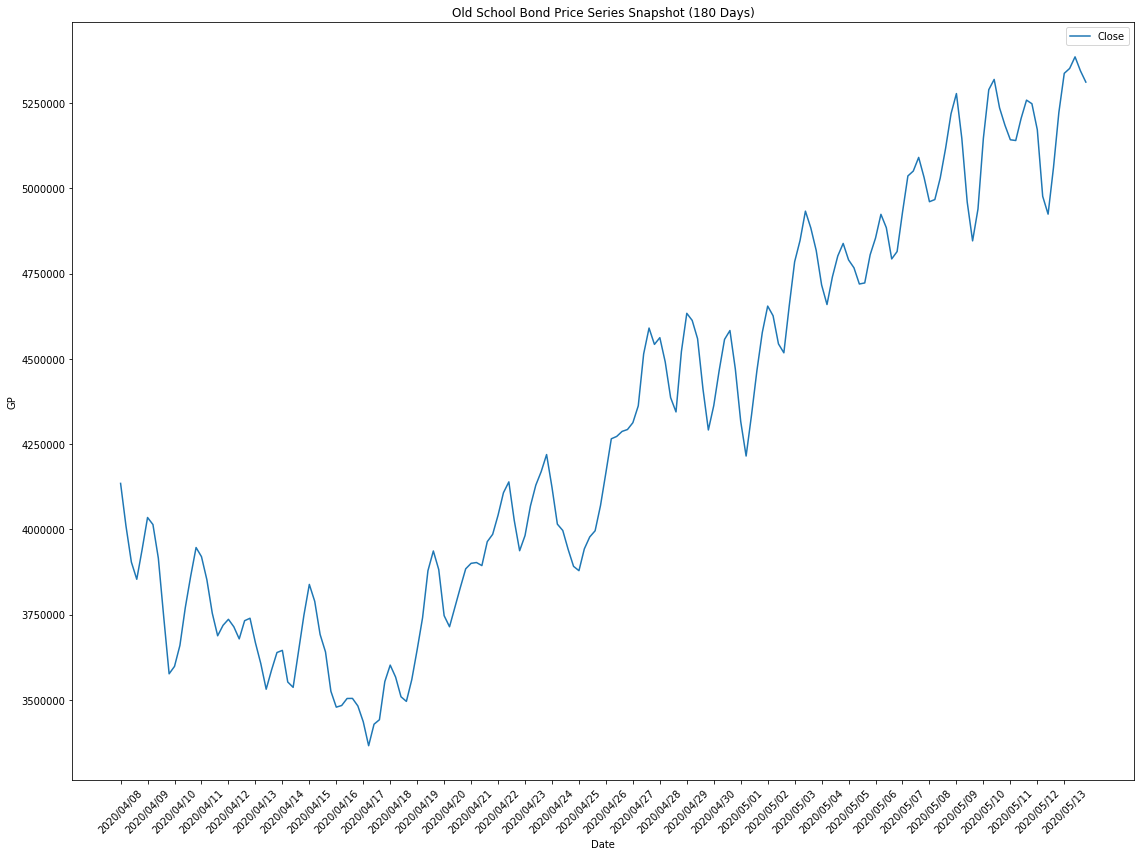

In [8]:
#plotting the closing price signal
fig, ax = plt.subplots()
ax.plot(timestamps, f)
ax.set(xlabel="Date", ylabel="GP", 
       title="Old School Bond Price Series Snapshot (180 Days)")
plt.xticks(np.arange(0, bond_df.shape[0], 5), rotation=45)
plt.legend()

# My mistake in transforming the close signal #

At first, I thought it would make sense to try and Fourier transform the price signal-if I could forecast the price, then I could calculate if there was a price change. But, if knowing the price change is what I want to know, it makes more sense to **make the price change the signal under study.**

An important consequence of analyzing the change between measurements is that differencing removes trend. This is generally good because many models (like ARMA) models assume stationary data. I noticed that by removing trend (seen in the next section) the power spectral density revealed dominating frequencies in the signal. This result is in contrast to the power spectral density seen in this section.

*The timescale on the data is 1 sample per day. This forces `dt = 1`*

In [9]:
#compute the FFT

#the number of data points
n = len(timestamps)
#the time range of the data set (days since start)
t = np.arange(0, n)

#the complex coefficients desc. the transform
fhat = np.fft.fft(f, n)
#power spectral density
PSD = fhat*np.conj(f)/n
#each fhat corresponds to a sinusoid with particular frequency
freq = (1/(n)) * np.arange(n)

/Users/nikourriola/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/nikourriola/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


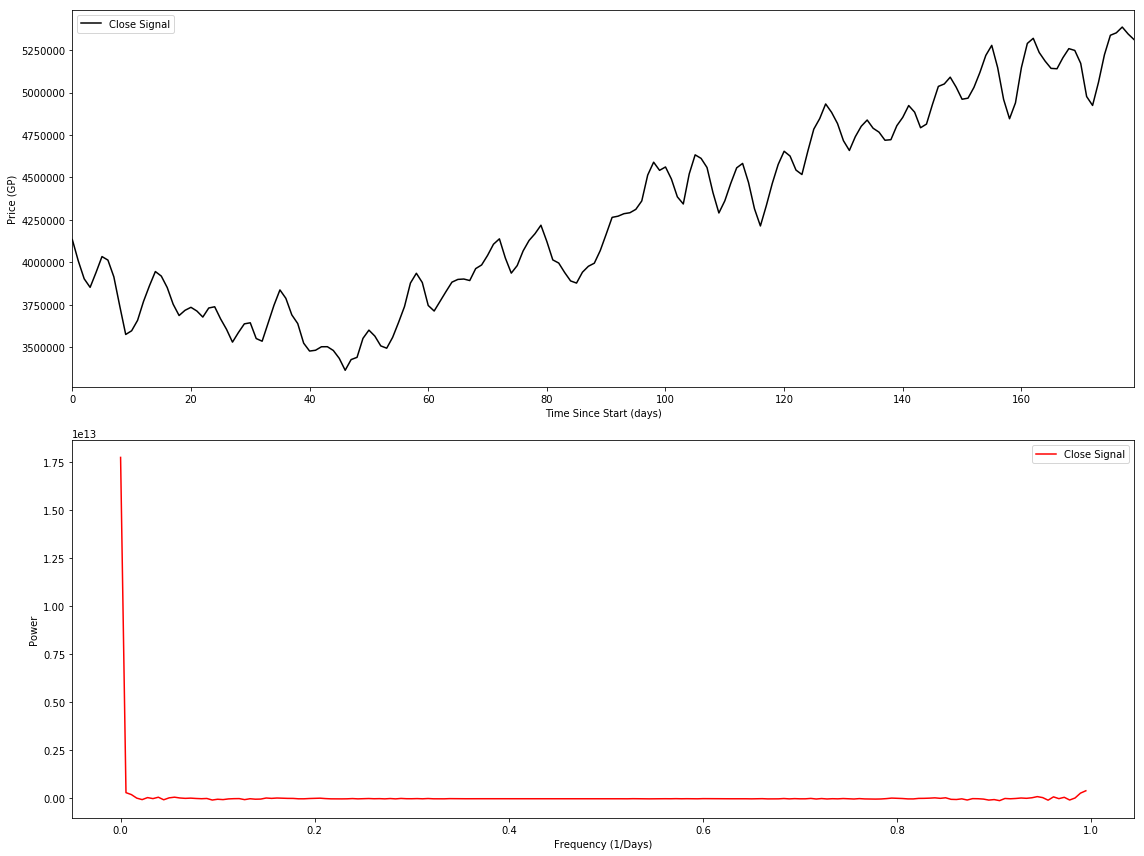

In [10]:
fig, ax = plt.subplots(2, 1)

plt.sca(ax[0])
plt.plot(t, f, color='k', label="Close Signal")
plt.xlabel("Time Since Start (days)")
plt.ylabel("Price (GP)")
plt.xlim(t[0], t[-1])
plt.legend()

plt.sca(ax[1])
plt.plot(freq, PSD, color='r', label="Close Signal")
plt.xlabel("Frequency (1/Days)")
plt.ylabel("Power")
plt.legend()

plt.show()

---

# Differenced Close Series #

The project goal is to develop profitable trading strategies based on models that describe *how the signal changes from one measurement to another* (will the price rise or fall and by how much?). Here, I calculate  the first order difference series and then extract the dominating frequencies of the signal.

See *My mistake in transforming the close signal* for further motivation

In [11]:
bond_df["Diff Close"] = bond_df["Close"].diff()
bond_df.head()

,Timestamps_close,Close,Timestamps_average,Average,Diff Close
Index,,,,,
0,2020/04/08,4134618,2020/04/08,4522980,NaN
1,2020/04/09,4009639,2020/04/09,4501601,-124979.0
2,2020/04/10,3903868,2020/04/10,4473252,-105771.0
3,2020/04/11,3853462,2020/04/11,4442300,-50406.0
4,2020/04/12,3941327,2020/04/12,4415261,87865.0


In [12]:
f_diff = bond_df["Diff Close"]
f_diff = f_diff.dropna()
f_diff.head()

Index
1   -124979.0
2   -105771.0
3    -50406.0
4     87865.0
5     93286.0
Name: Diff Close, dtype: float64

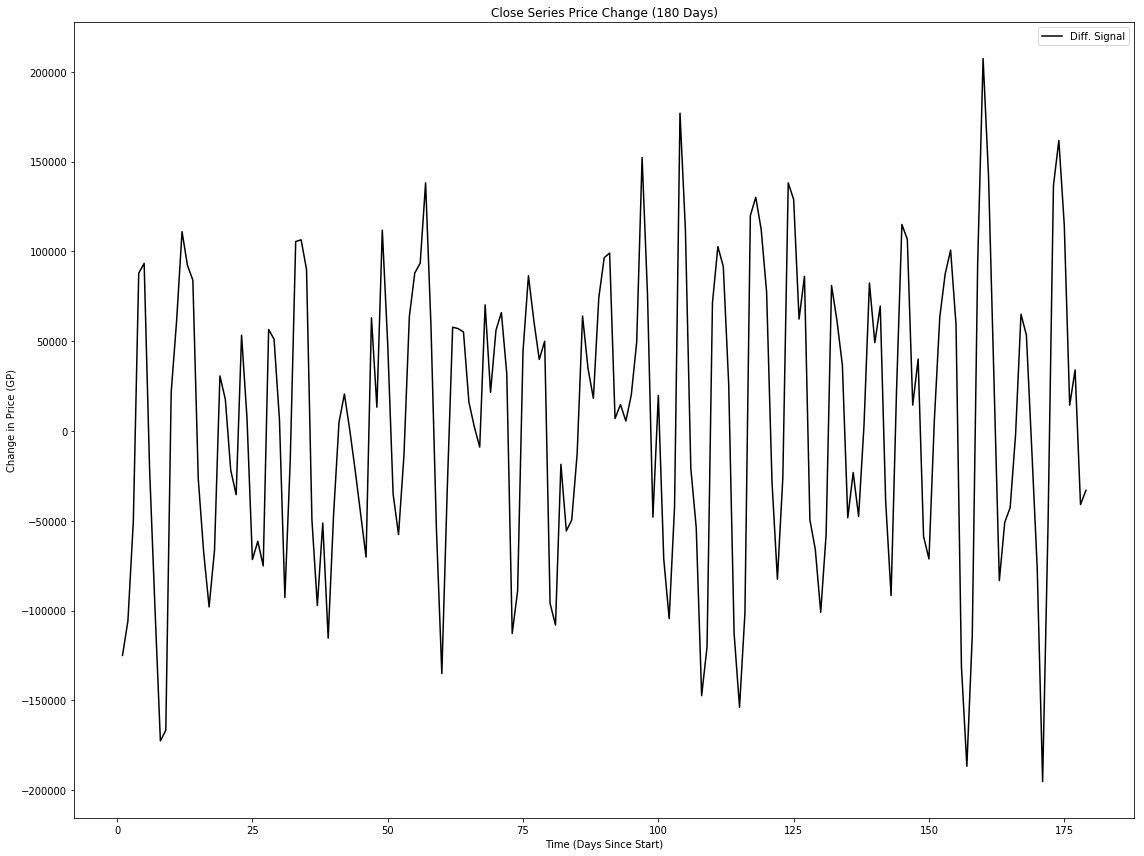

In [13]:
#simple plot of the differenced series over time

plt.plot(np.arange(1, len(f_diff)+1), f_diff, color='k', label="Diff. Signal")
plt.xlabel("Time (Days Since Start)")
plt.ylabel("Change in Price (GP)")
plt.title("Close Series Price Change (180 Days)")
plt.legend()
plt.show()

# Checking for Stationarity in Differenced Close Series #

H<sub>0</sub>:  The series has a unit root (is non-stationary)  
H<sub>A</sub>:  The series is stationary

In [14]:
result = adfuller(f_diff)
#more negative means, stronger rejection of null hypothesis
print("ADF Statistic {}".format(result[0]))
print("p-value {}".format(result[1]))

ADF Statistic -5.0457094142082175
p-value 1.8006161422845505e-05


**Reject H<sub>0</sub>**  

I'm not going to try and eliminate volatility through time because that fluctuation should be captured by the Fourier transform

# Fast Fourier Transform of Old School Bond Differenced Series #

In [15]:
#compute the FFT

#the number of data points
n = len(f_diff)
#the time range of the data set (days since start)
t = np.arange(0, n)

#the complex coefficients desc. the transform
fhat = np.fft.fft(f_diff, n)
#power spectral density
PSD = fhat*np.conj(fhat)/n
#each fhat corresponds to a sinusoid with particular frequency
freq = (1/(n))*np.arange(n)

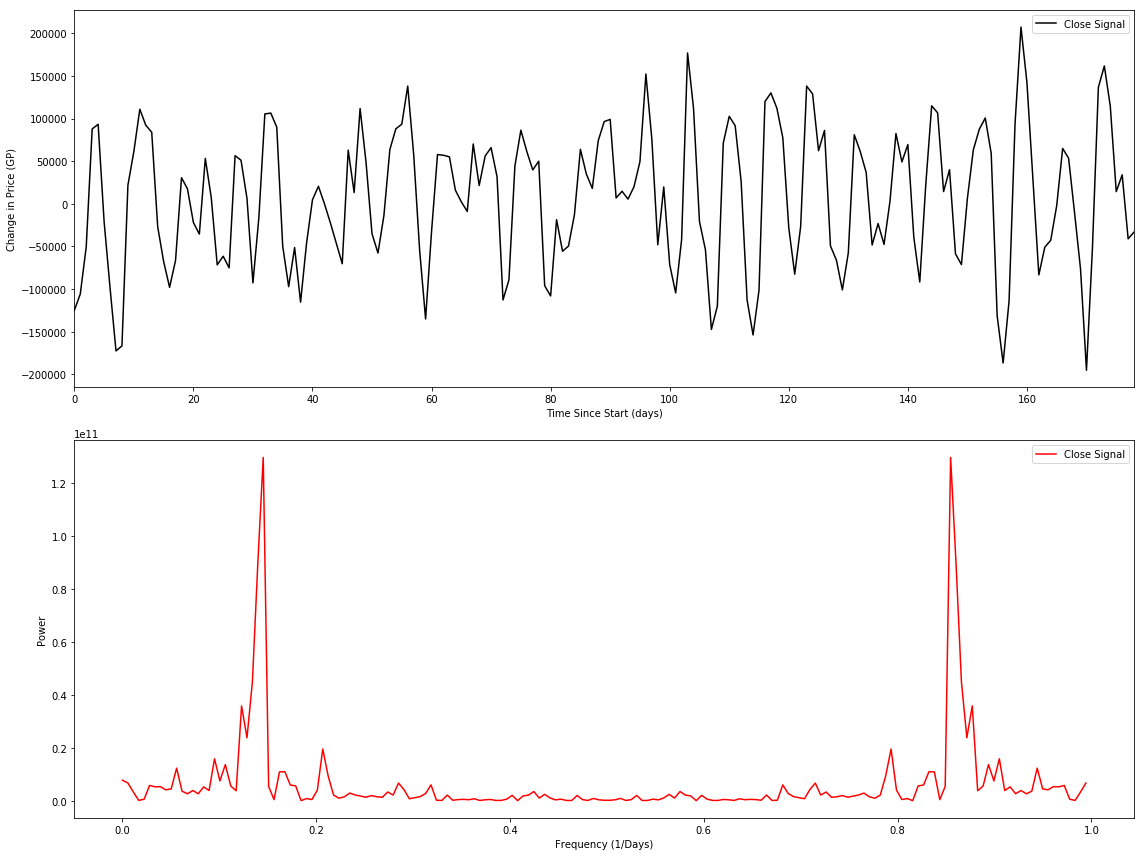

In [16]:
fig, ax = plt.subplots(2, 1)

plt.sca(ax[0])
plt.plot(t, f_diff, color='k', label="Close Signal")
plt.xlabel("Time Since Start (days)")
plt.ylabel("Change in Price (GP)")
plt.xlim(t[0], t[-1])
plt.legend()

plt.sca(ax[1])
plt.plot(freq, PSD, color='r', label="Close Signal")
plt.xlabel("Frequency (1/Days)")
plt.ylabel("Power")
plt.legend()

plt.show()

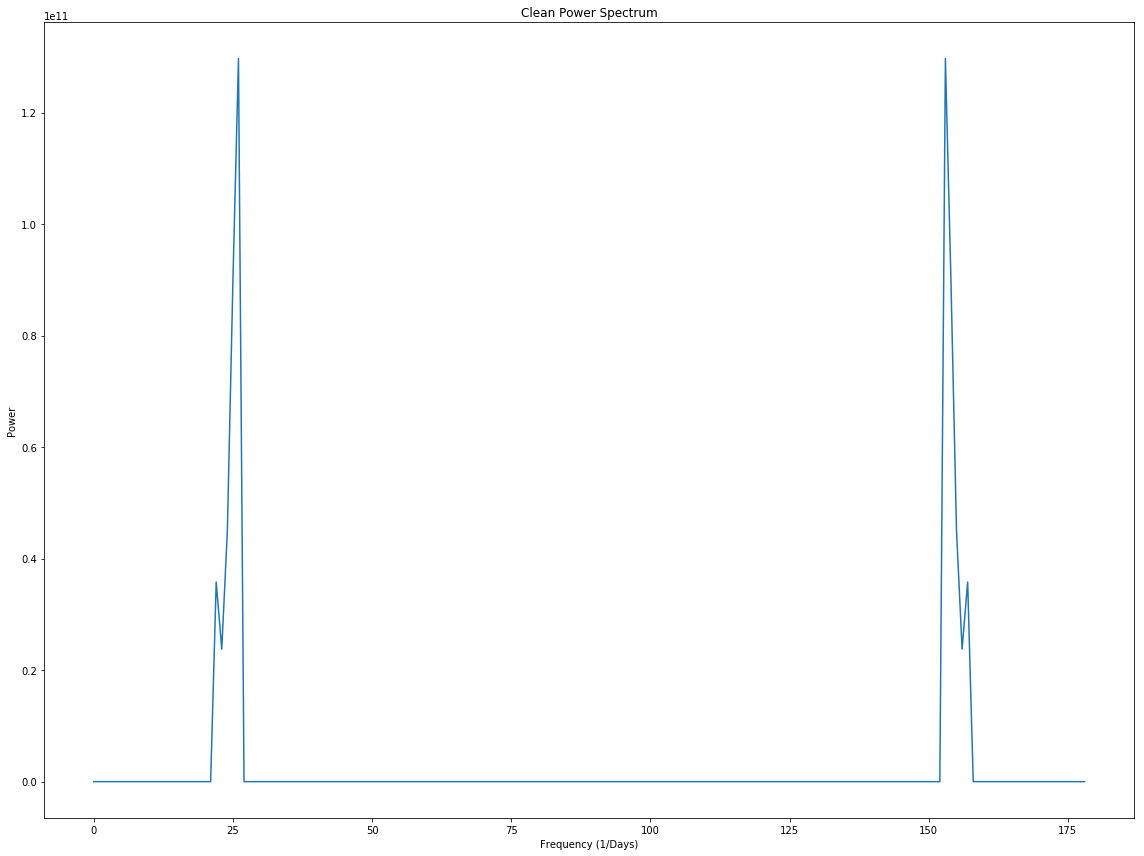

In [17]:
indices = PSD>(0.2e11)
PSDClean = PSD*indices
plt.plot(np.arange(len(PSD)), PSDClean)
plt.xlabel("Frequency (1/Days)")
plt.ylabel("Power")
plt.title("Clean Power Spectrum")
plt.show()

In [18]:
f_filtered = fhat*indices
f_forecast = np.fft.ifft(f_filtered)

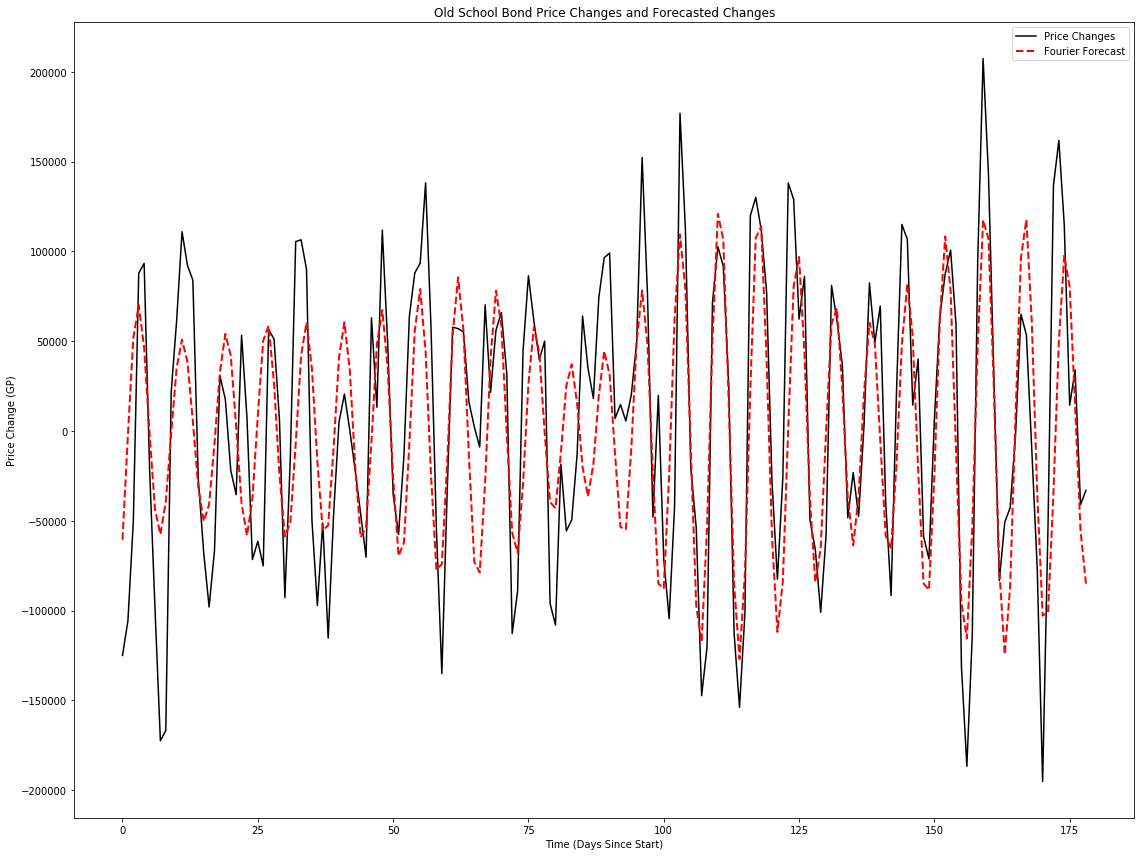

In [19]:
plt.plot(t, f_diff, color='k', label="Price Changes")
plt.plot(t, f_forecast, "r--", label="Fourier Forecast", LineWidth=2)
plt.xlabel("Time (Days Since Start)")
plt.ylabel("Price Change (GP)")
plt.legend()
plt.title("Old School Bond Price Changes and Forecasted Changes")
plt.show()

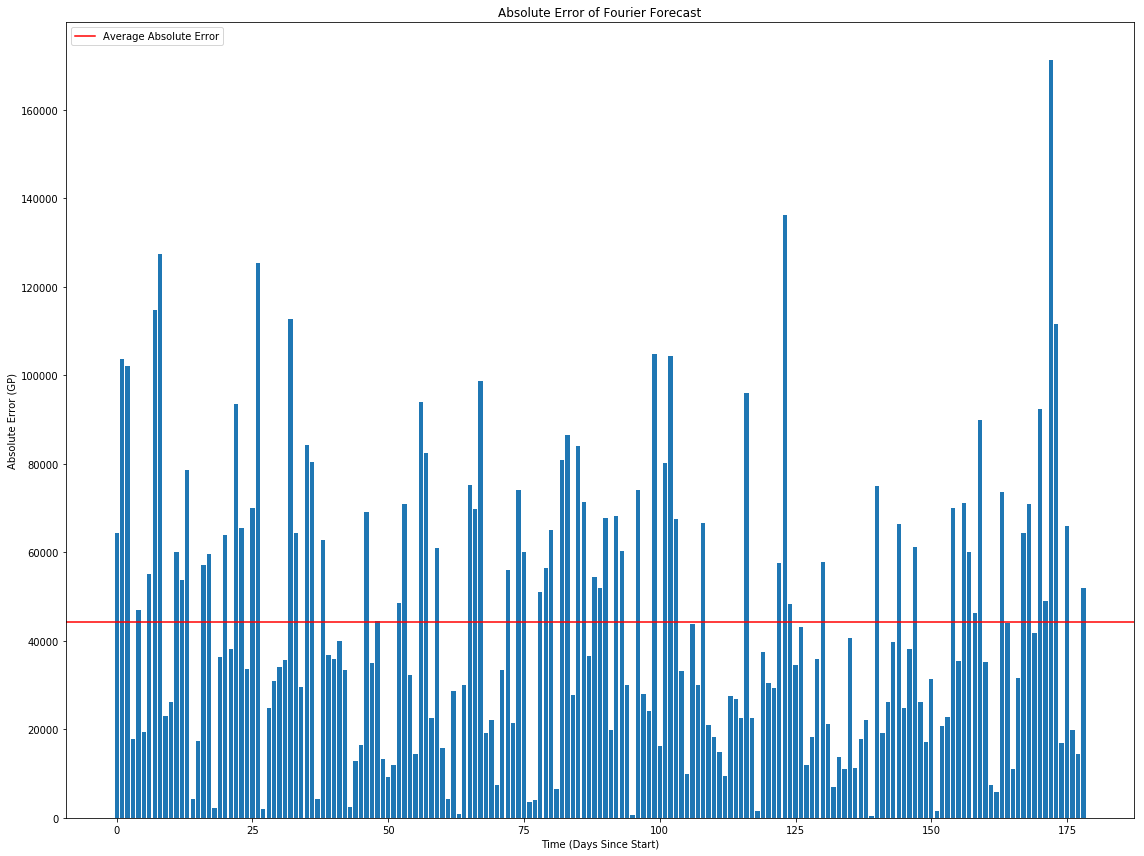

In [20]:
#what does the error look like over time?
series = {"Diff Close":bond_df["Diff Close"].dropna(), "Fourier Close":f_forecast}
error_df = pd.DataFrame(series)
error_df["Absolute Error"] = abs(error_df["Diff Close"] - error_df["Fourier Close"])

#mean absolute error
mean_abs = error_df["Absolute Error"].mean()

#absolute error graph
plt.bar(np.arange(0, error_df.shape[0]), error_df["Absolute Error"])
plt.axhline(y=mean_abs, color="red", label="Average Absolute Error")
plt.xlabel("Time (Days Since Start)")
plt.ylabel("Absolute Error (GP)")
plt.title("Absolute Error of Fourier Forecast")
plt.legend(loc="upper left")
plt.show()

In [21]:
#proportion of time the absolute error is below average
error_df["Below Average Error"] = error_df["Absolute Error"]<mean_abs
pcts = error_df["Below Average Error"].value_counts()/error_df.shape[0]
pcts

True     0.581006
False    0.418994
Name: Below Average Error, dtype: float64

About 58% of the time the forecasted results are wrong, but below how wrong the forecast is on average

---

## Concluding thoughts about Fourier forecast ##

Looking at *Old School Bond Price Changes and Forecasted Changes* I see only 3 places in the snapshot where the forecast failed to capture the local trend. Specifically at ~80 to ~95 days since start the red, dashed line oscillates from a peak through a trough and back to a peak. In contrast, in the same time period, the black line oscillates in the opposite pattern (trough to peak and back to trough). 

There are also some very fast oscillations that the price signal makes that are "smoothed out" by the forecast. Notice at ~130 days, the price signal had a sudden price spike that reset within 1 or 2 days. In the same period, the forecast smoothly transitions through a trough.  

I think, then, the forecast could be useful in determining the direction of a price change but not the magnitude. 

I'm curious to see how the forecast compares to:
- The 2 day moving average of the differenced series
    - moving averages are known to "smooth outh" a time series 
    - 2 days because the differenced signal is the difference b/n 2 adjacent days
- The differenced average price
    - to see what the absolute error will do

In [30]:
#collecting and processing the above time series
bond_df["Diff Average"] = bond_df["Average"].diff()
bond_df["Diff 2DMA"] = bond_df["Diff Close"].rolling(2).mean()
bond_df.head(14)

,Timestamps_close,Close,Timestamps_average,Average,Diff Close,Diff Average,2DMA,Diff 2DMA
Index,,,,,,,,
0,2020/04/08,4134618,2020/04/08,4522980,NaN,NaN,NaN,NaN
1,2020/04/09,4009639,2020/04/09,4501601,-124979.0,-21379.0,4072128.5,NaN
2,2020/04/10,3903868,2020/04/10,4473252,-105771.0,-28349.0,3956753.5,-115375.0
3,2020/04/11,3853462,2020/04/11,4442300,-50406.0,-30952.0,3878665.0,-78088.5
4,2020/04/12,3941327,2020/04/12,4415261,87865.0,-27039.0,3897394.5,18729.5
5,2020/04/13,4034613,2020/04/13,4392554,93286.0,-22707.0,3987970.0,90575.5
6,2020/04/14,4013946,2020/04/14,4369056,-20667.0,-23498.0,4024279.5,36309.5
7,2020/04/15,3915445,2020/04/15,4339586,-98501.0,-29470.0,3964695.5,-59584.0
8,2020/04/16,3742945,2020/04/16,4301351,-172500.0,-38235.0,3829195.0,-135500.5


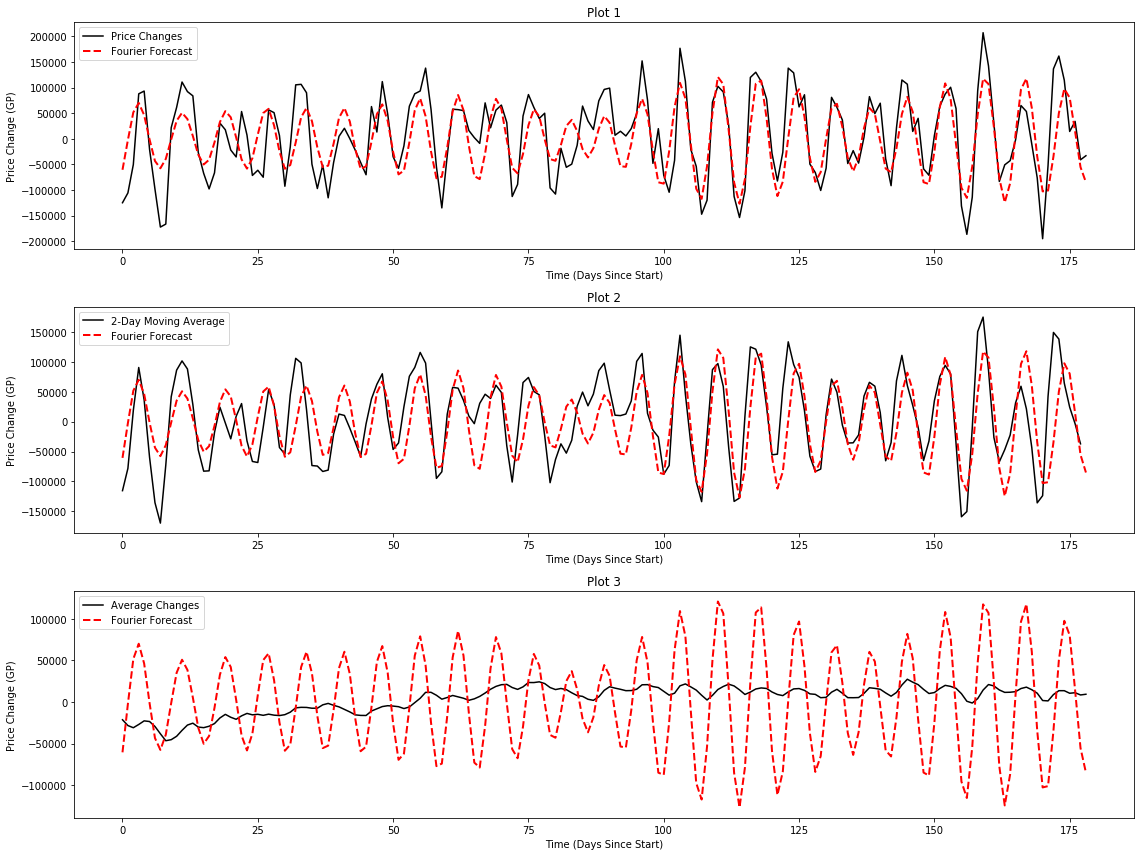

In [34]:
diff_avg = bond_df["Diff Average"].dropna()
dma_2 = bond_df["Diff 2DMA"].dropna()

fig, ax = plt.subplots(3, 1)

plt.sca(ax[0])
plt.plot(t, f_diff, color='k', label="Price Changes")
plt.plot(t, f_forecast, "r--", label="Fourier Forecast", LineWidth=2)
plt.xlabel("Time (Days Since Start)")
plt.ylabel("Price Change (GP)")
plt.legend()
plt.title("Plot 1")

plt.sca(ax[1])
plt.plot(np.arange(0, len(dma_2)), dma_2, color='k', label="2-Day Moving Average")
plt.plot(t, f_forecast, "r--", label="Fourier Forecast", LineWidth=2)
plt.xlabel("Time (Days Since Start)")
plt.ylabel("Price Change (GP)")
plt.legend()
plt.title("Plot 2")

plt.sca(ax[2])
plt.plot(t, diff_avg, color='k', label="Average Changes")
plt.plot(t, f_forecast, "r--", label="Fourier Forecast", LineWidth=2)
plt.xlabel("Time (Days Since Start)")
plt.ylabel("Price Change (GP)")
plt.legend()
plt.title("Plot 3")

plt.show()

(*NB it's easier to title Plot 1-3 here, for this write up part*)

**Plot 1**  
Same plot as before just grouped with 2 others.

**Plot 2**  
Moving averages tend to smooth out signals. I can see that in the window near ~130 days, the sudden jump/reset in the signal is removed in this moving average plot. As a result, the forecast agrees nicely with the signal. I think this, again, speaks to the ability of this particular model at predicting the direction of change. For a beginning trade strategy, knowing the direction might be enough to get started; specifically, when managing time spent on money makers. 

*(Example)*  
*I can spend 30 min collecting chinchompas (instead of a full hour) because I know that bond prices will fall soon; I don't need as much cash as fast as previously thought*

**Plot 3**  
The Fourier forecast fails at predicting either average prices and average price swings. The absolute error will clearly be worse here.  